In [88]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning) 

start = time.perf_counter()

In [89]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1049 non-null   object 
 1   SeasonNumber       1049 non-null   int64  
 2   SeasonVersion      1049 non-null   int64  
 3   Player             1049 non-null   object 
 4   MatchId            1049 non-null   object 
 5   Map                1049 non-null   object 
 6   Category           1049 non-null   object 
 7   Playlist           1049 non-null   object 
 8   Input              1049 non-null   object 
 9   Queue              1049 non-null   object 
 10  PreCsr             1049 non-null   int64  
 11  PostCsr            1049 non-null   int64  
 12  Rank               1049 non-null   int64  
 13  WasAtStart         1049 non-null   int64  
 14  WasAtEnd           1049 non-null   int64  
 15  WasInProgressJoin  1049 non-null   int64  
 16  Mmr                2 non

In [90]:
# General Fixes+Additions
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
# Ratios
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['Damage/Life'] = df['DamageDone'] / df['Deaths'].replace(0,1)
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Damage/KA'] = df['DamageDone'] / (df['Kills'] + df['Assists'])
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
# df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.describe()

,Outcome,Accuracy,DamageDone,DamageTaken,KD,KDA,Kills,Deaths,Assists,MaxSpree,...,Dmg/10Min,DmgT/10Min,Shots/10Min,ExcessKills,ExcessDeaths,BodyPct,MeleePct,HSPct,GrenadePct,PowerPct
count,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,...,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000
mean,0.551813,52.762837,5282.861399,4531.163212,1.266813,4.494650,14.549223,12.928756,8.628238,3.937824,...,4971.117084,4241.996618,222.175612,0.000000,1.648964,28.327843,9.495447,53.251877,7.048989,1.875844
std,0.497631,5.529685,1801.103309,1534.477929,0.739416,5.713476,6.222541,5.115157,4.258554,1.598076,...,839.398439,689.572037,41.529539,4.055388,2.564820,14.091255,8.180900,14.802021,7.956301,5.348943
min,0.000000,20.450000,619.000000,0.000000,0.270000,-10.000000,1.000000,0.000000,0.000000,1.000000,...,1209.771987,0.000000,67.741935,-11.000000,-7.000000,-12.500000,0.000000,11.111111,0.000000,0.000000
25%,0.000000,49.327500,3924.250000,3488.750000,0.850000,0.660000,10.000000,9.000000,6.000000,3.000000,...,4451.980502,3859.793508,196.650115,-3.000000,0.000000,20.000000,0.000000,43.750000,0.000000,0.000000
50%,1.000000,52.800000,5058.000000,4363.000000,1.120000,4.330000,14.000000,13.000000,8.000000,4.000000,...,4981.744703,4323.402673,221.975610,0.000000,2.000000,27.777778,8.695652,53.333333,5.555556,0.000000
75%,1.000000,56.135000,6505.000000,5565.500000,1.460000,8.000000,18.000000,16.000000,11.000000,5.000000,...,5501.987545,4726.526865,246.255596,2.000000,3.000000,37.500000,14.285714,63.636364,11.111111,0.000000
max,1.000000,80.560000,12673.000000,9962.000000,10.000000,31.000000,40.000000,32.000000,28.000000,12.000000,...,7302.793296,6345.913819,475.662651,17.000000,10.000000,77.777778,40.000000,100.000000,50.000000,40.000000


In [91]:
dfRR.describe().transpose()
# dfRR[dfRR['Damage/Life']==np.nan]

,count,mean,std,min,25%,50%,75%,max
Outcome,772.0,0.551813,0.497631,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,772.0,52.762837,5.529685,20.450000,49.327500,52.800000,56.135000,80.560000
DamageDone,772.0,5282.861399,1801.103309,619.000000,3924.250000,5058.000000,6505.000000,12673.000000
DamageTaken,772.0,4531.163212,1534.477929,0.000000,3488.750000,4363.000000,5565.500000,9962.000000
KD,772.0,1.266813,0.739416,0.270000,0.850000,1.120000,1.460000,10.000000
KDA,772.0,4.494650,5.713476,-10.000000,0.660000,4.330000,8.000000,31.000000
Kills,772.0,14.549223,6.222541,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,772.0,12.928756,5.115157,0.000000,9.000000,13.000000,16.000000,32.000000
Assists,772.0,8.628238,4.258554,0.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,772.0,3.937824,1.598076,1.000000,3.000000,4.000000,5.000000,12.000000


In [92]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.439994
DmgT/10Min        0.366231
Damage/Life       0.328103
Deaths            0.325419
KD                0.324496
KDA               0.290496
Damage/KA         0.287875
DamageTaken       0.258675
ExcessDeaths      0.256634
ExpectedDeaths    0.217390
Damage/Kill       0.189695
Assists/10Min     0.169679
Kills/10Min       0.154174
LengthMinutes     0.143697
DamageDone        0.098244
Accuracy          0.091578
MaxSpree          0.080711
Assists           0.052250
ExpectedKills     0.043655
HSPct             0.040959
BodyPct           0.038963
DamageRatio       0.036700
Score             0.033007
Dmg/10Min         0.031285
ExcessKills       0.028279
PowerPct          0.020784
Kills             0.012553
GrenadePct        0.009421
Medals            0.008287
Shots/10Min       0.004166
MeleePct          0.002571
Name: Outcome, dtype: float64


In [93]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [94]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (772, 31)
Y Shape: (772,)


In [95]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=6)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
# print(X_train.columns)
print(f'Y Train Mean: {round(y_train.mean(),3)}')
print(f'Y Test Mean: {round(y_test.mean(),3)}')

X Train Shape: (617, 31)
X Test Shape: (155, 31)
Y Train Mean: 0.571
Y Test Mean: 0.477


In [96]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 
                                    'KDA', 'MaxSpree', 'Deaths', 'Assists', 'Kills', 'DamageDone', 
                                    'DamageTaken', 'Score', 'Medals', 'LengthMinutes', 
                                    'DamageRatio', 'Damage/Kill', 'Damage/KA', 'Damage/Life',
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_pp = pipeline.fit_transform(X_train)
X_test_pp = pipeline.transform(X_test)

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_pp, X_val_pp, y_train, y_val = train_test_split(X_train_pp, y_train, test_size=0.2, random_state=2)

# X_train_preprocessed.to_csv('X_train_preprocessed.csv')
# X_test_preprocessed.to_csv('X_test_preprocessed.csv')
print(f'X Train Processed Shape: {X_train_pp.shape}')
print(f'X Val Processed Shape: {X_val_pp.shape}')
print(f'X Test Processed Shape: {X_test_pp.shape}')
print(f'Y Train Shape: {y_train.shape}')
print(f'Y Val Shape: {y_val.shape}')
print(f'Y Test Shape: {y_test.shape}')

X Train Processed Shape: (493, 31)
X Val Processed Shape: (124, 31)
X Test Processed Shape: (155, 31)
Y Train Shape: (493,)
Y Val Shape: (124,)
Y Test Shape: (155,)


In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'activation': ['logistic', 'tanh', 'relu', 'identity'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'adaptive']
}

# Perform grid search
grid_search = GridSearchCV(MLPClassifier(random_state=27), param_grid, cv=5)
grid_search.fit(X_train_pp, y_train)

# Get the best parameters and model
best_mlp = grid_search.best_estimator_
best_mlp_stats = {
    'Training Accuracy': best_mlp.score(X_train_pp, y_train),
    'Validation Accuracy': best_mlp.score(X_val_pp, y_val),
    'Test Accuracy': best_mlp.score(X_test_pp, y_test)
}
print(best_mlp_stats)
print(best_mlp)

{'Training Accuracy': 0.8174442190669371, 'Validation Accuracy': 0.8629032258064516, 'Test Accuracy': 0.8129032258064516}
MLPClassifier(activation='identity', alpha=1, random_state=27, solver='lbfgs')


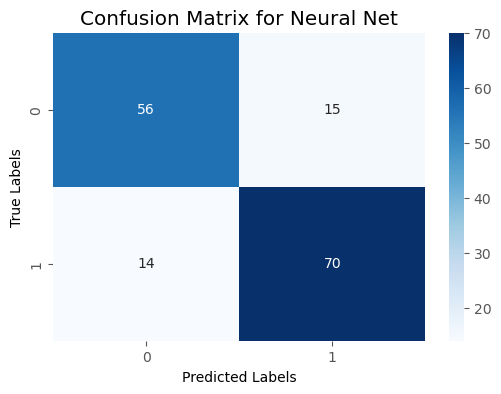

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<Axes: >

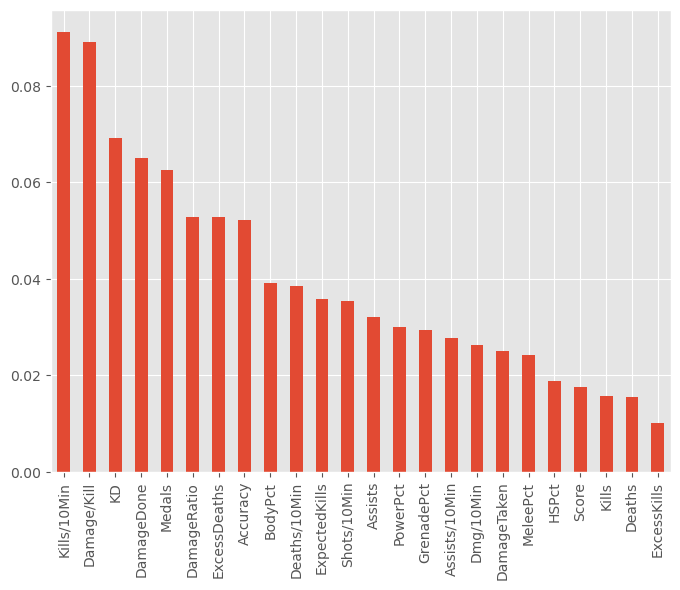

In [49]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, best_mlp.predict(X_test_pp))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_mlpc = pd.DataFrame(best_mlp.coefs_[0].flatten()[:31], index=X_train.columns, columns=["Importance"])
feat_importances_mlpc = feat_importances_mlpc.abs().sum(axis=1)
feat_importances_mlpc = feat_importances_mlpc / feat_importances_mlpc.sum()
feat_importances_mlpc = feat_importances_mlpc.sort_values(ascending=False)[:24]
feat_importances_mlpc.plot(kind='bar', figsize=(8,6))

## Torch Simple Neural Net

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

y_train_array = y_train.values
y_val_array = y_val.values

# Then create tensors from the NumPy arrays
X_train_pp_tensor = torch.tensor(X_train_pp, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)
X_val_pp_tensor = torch.tensor(X_val_pp, dtype=torch.float)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.long)

In [98]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Instantiate the model
input_size = 31  # Replace with the actual input size
hidden_size = 15 # Replace with the desired hidden layer size
output_size = 2  # Replace with the actual output size
model = SimpleNeuralNet(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

val_losses = []
losses = []
val_accuracies = []
accuracies = []

prev_loss = float('inf')
prev_val_loss = float('inf')  # Initialize with a large value

for epoch in tqdm(range(50000)):
    optimizer.zero_grad()
    outputs = model(X_train_pp_tensor)
    loss = criterion(outputs, y_train_tensor)
    prev_loss = loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # Calculate training accuracy
    with torch.no_grad():
        predicted = torch.argmax(outputs, 1)
        correct = (predicted == y_train_tensor).sum().item()
        accuracy = correct / y_train_tensor.size(0)
        accuracies.append(accuracy)
        
        # Calculate validation loss and accuracy
        val_outputs = model(X_val_pp_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
        val_predicted = torch.argmax(val_outputs, 1)
        val_correct = (val_predicted == y_val_tensor).sum().item()
        val_accuracy = val_correct / y_val_tensor.size(0)
        val_accuracies.append(val_accuracy)
        
        prev_val_loss = val_loss


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:55<00:00, 895.38it/s] 


In [99]:
# from torch.utils.data import TensorDataset, DataLoader

# # Convert training and validation data to TensorDataset
# train_dataset = TensorDataset(torch.tensor(X_train_pp, dtype=torch.float),
#                               torch.tensor(y_train_array, dtype=torch.long))
# val_dataset = TensorDataset(torch.tensor(X_val_pp, dtype=torch.float),
#                             torch.tensor(y_val_array, dtype=torch.long))

# # Define batch size
# batch_size = 32  # Replace with your desired batch size

# # Create DataLoader objects for batching
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# # Inside your training loop
# for epoch in tqdm(range(10000)):
#     for batch in train_loader:
#         optimizer.zero_grad()
#         inputs, targets = batch
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
    
#     # Calculate training accuracy
#     model.eval()  # Set model to evaluation mode
#     with torch.no_grad():
#         train_correct = 0
#         total_train = 0
#         for batch in train_loader:
#             inputs, targets = batch
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total_train += targets.size(0)
#             train_correct += (predicted == targets).sum().item()
#         train_accuracy = train_correct / total_train
#         accuracies.append(train_accuracy)

#     # Calculate validation loss and accuracy
#     model.eval()  # Set model to evaluation mode
#     with torch.no_grad():
#         val_loss = 0
#         val_correct = 0
#         total_val = 0
#         for batch in val_loader:
#             inputs, targets = batch
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total_val += targets.size(0)
#             val_correct += (predicted == targets).sum().item()
#         val_accuracy = val_correct / total_val
#         val_losses.append(val_loss / len(val_loader))
#         val_accuracies.append(val_accuracy)


In [100]:
# Assuming X_test_preprocessed and y_test are your test data
X_test_pp_tensor = torch.tensor(X_test_pp, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_pp_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_predicted = torch.argmax(test_outputs, 1)
    test_correct = (test_predicted == y_test_tensor).sum().item()
    test_accuracy = test_correct / y_test_tensor.size(0)

print(f'Epochs: {len(losses)}')
print(f'Training Loss: {loss}')
print(f'Training Accuracy: {accuracy}')
print(f'Validation Loss: {val_losses[-1]}')
print(f'Validation Accuracy: {val_accuracies[-1]}')
print(f'Test Loss: {test_loss.item()}')
print(f'Test Accuracy: {test_accuracy}')


Epochs: 50000
Training Loss: 0.4132179021835327
Training Accuracy: 0.922920892494929
Validation Loss: 0.5126480460166931
Validation Accuracy: 0.7661290322580645
Test Loss: 0.54444819688797
Test Accuracy: 0.7419354838709677


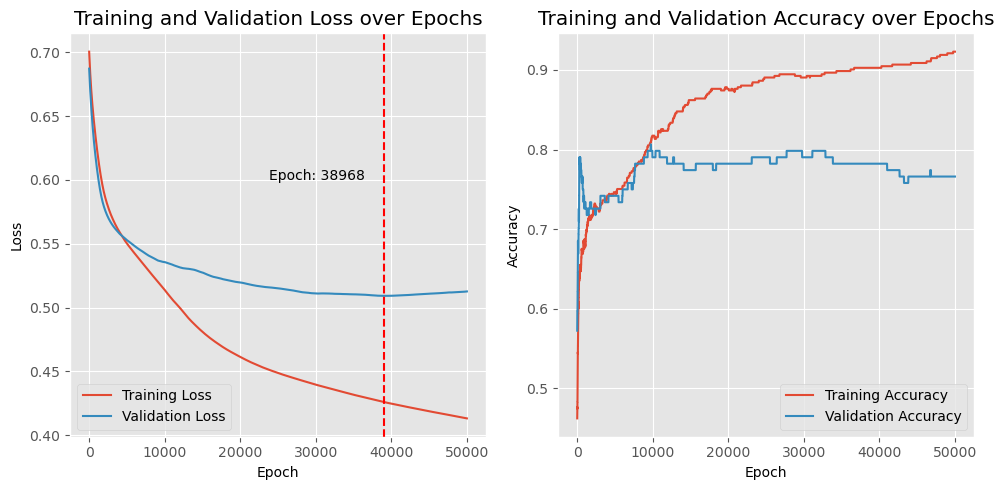

In [101]:
import matplotlib.pyplot as plt
epochs = range(1, len(losses) + 1)

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Plotting a line on the x-axis where Validation Loss is at its lowest
min_val_loss_epoch = val_losses.index(min(val_losses)) + 1
tenPCT = len(val_losses) * 0.05

plt.axvline(x=min_val_loss_epoch, color='r', linestyle='--')
plt.text(min_val_loss_epoch - tenPCT, 0.6, f'Epoch: {min_val_loss_epoch}', ha='right')

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()
